Loading engineered datasets...

Training XGBoost v2...

XGBoost v2 RESULTS:
  RMSE: 35.3419
  MAE : 27.5920
  MAPE: 15.24%

Training LightGBM v2...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4759
[LightGBM] [Info] Number of data points in the train set: 226523, number of used features: 23
[LightGBM] [Info] Start training from score 203.309682

LightGBM v2 RESULTS:
  RMSE: 34.9393
  MAE : 27.2007
  MAPE: 15.04%

Training CatBoost v2...
0:	learn: 81.8923694	total: 178ms	remaining: 2m 57s
200:	learn: 29.7879615	total: 7.15s	remaining: 28.4s
400:	learn: 25.7346539	total: 13.6s	remaining: 20.3s
600:	learn: 22.3951448	total: 20.4s	remaining: 13.5s
800:	learn: 19.6464186	total: 27.2s	remaining: 6.76s
999:	learn: 17.2544144	total: 34s	remaining: 0us

CatBoost v2 RESULTS:
  RMSE: 33.558

C:\Users\kasiv\AppData\Local\Temp\ipykernel_19984\72195378.py:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp.values, y=imp.index, palette="viridis")


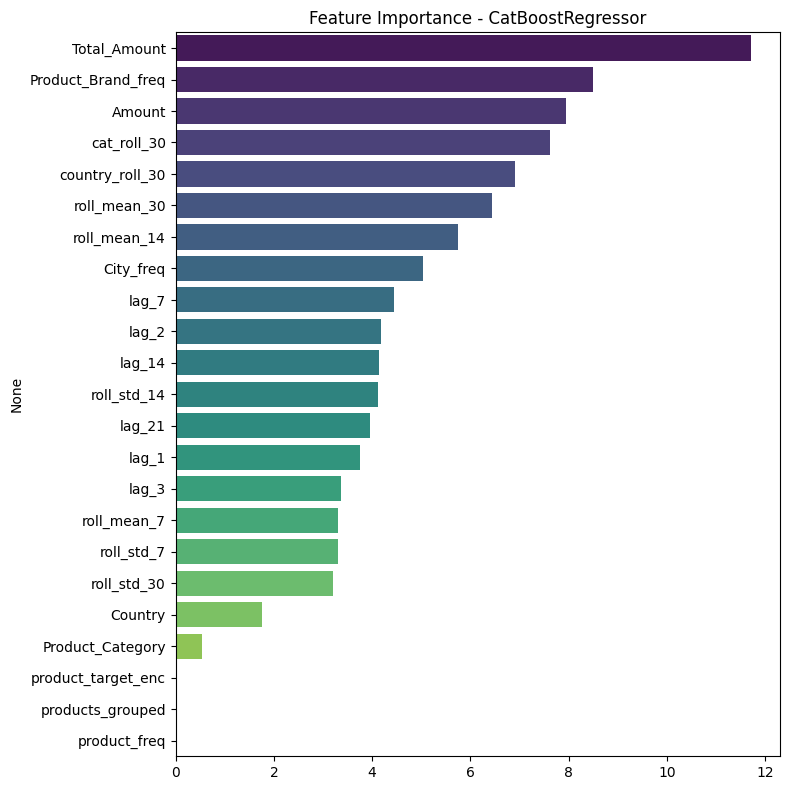


Plotting predictions...


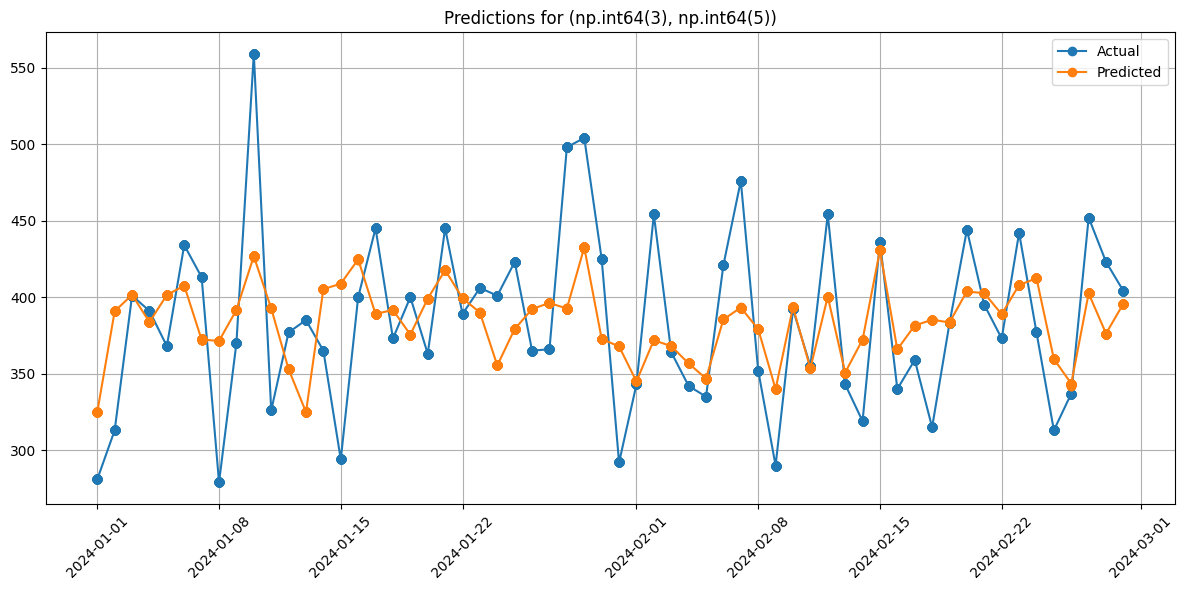

Saving test predictions...

Model Building v2 Complete ✓


In [3]:
# ===========================================================
# MODEL BUILDING v2
# Works with final_train_v2.csv and final_test_v2.csv
# Includes: XGBoost, LightGBM, CatBoost, TSS CV, plots, importance
# ===========================================================

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from math import sqrt

# Try loading model libraries
try:
    import xgboost as xgb
except:
    xgb = None

try:
    import lightgbm as lgb
except:
    lgb = None

try:
    from catboost import CatBoostRegressor
except:
    CatBoostRegressor = None

# ===========================================================
# UTILITY FUNCTIONS
# ===========================================================

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, 1, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def evaluate(name, y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    print(f"\n{name} RESULTS:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  MAPE: {mape_val:.2f}%")
    return {"model": name, "rmse": rmse, "mae": mae, "mape": mape_val}

# ===========================================================
# 1. LOAD FINAL FEATURE DATASETS (v2)
# ===========================================================

print("Loading engineered datasets...")
train = pd.read_csv("../data/final_train_v2.csv", parse_dates=["Date"])
test  = pd.read_csv("../data/final_test_v2.csv",  parse_dates=["Date"])

train = train.sort_values(["Product_Category","Country","Date"])
test  = test.sort_values(["Product_Category","Country","Date"])

TARGET = "Total_Purchases"

# Exclude non-features
drop_cols = ["Date"]
feature_cols = [c for c in train.columns if c not in drop_cols + [TARGET]]

X_train = train[feature_cols].copy()
y_train = train[TARGET].copy()

X_test = test[feature_cols].copy()
y_test = test[TARGET].copy()

# ===========================================================
# 2. OPTIONAL SCALING (Safe for tree models but helpful)
# ===========================================================

num_cols = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])
joblib.dump(scaler, "scaler_v2.joblib")

# ===========================================================
# 3. MODEL TRAINING
# ===========================================================

results = []
best_model = None
best_score = float("inf")

# ---------------------------
# XGBOOST
# ---------------------------
if xgb is not None:
    print("\nTraining XGBoost v2...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=600,
        learning_rate=0.04,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist"
    )
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    r = evaluate("XGBoost v2", y_test, y_pred)
    results.append(r)
    joblib.dump(xgb_model, "xgb_model_v2.joblib")
    if r["rmse"] < best_score:
        best_model = xgb_model
        best_score = r["rmse"]
else:
    print("XGBoost not installed.")

# ---------------------------
# LIGHTGBM
# ---------------------------
if lgb is not None:
    print("\nTraining LightGBM v2...")
    lgb_model = lgb.LGBMRegressor(
        n_estimators=1500,
        learning_rate=0.03,
        num_leaves=50,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    r = evaluate("LightGBM v2", y_test, y_pred)
    results.append(r)
    joblib.dump(lgb_model, "lgb_model_v2.joblib")
    if r["rmse"] < best_score:
        best_model = lgb_model
        best_score = r["rmse"]
else:
    print("LightGBM not installed.")

# ---------------------------
# CATBOOST
# ---------------------------
if CatBoostRegressor is not None:
    print("\nTraining CatBoost v2...")
    cb_model = CatBoostRegressor(
        iterations=1000,
        depth=8,
        learning_rate=0.03,
        loss_function="RMSE",
        verbose=200
    )
    cb_model.fit(X_train, y_train)
    y_pred = cb_model.predict(X_test)
    r = evaluate("CatBoost v2", y_test, y_pred)
    results.append(r)
    cb_model.save_model("catboost_model_v2.cbm")
    if r["rmse"] < best_score:
        best_model = cb_model
        best_score = r["rmse"]
else:
    print("CatBoost not installed.")

# ===========================================================
# 4. PRINT SUMMARY TABLE
# ===========================================================
res_df = pd.DataFrame(results).sort_values("rmse")
print("\nMODEL PERFORMANCE SUMMARY:")
print(res_df)

# ===========================================================
# 5. FEATURE IMPORTANCE
# ===========================================================

def plot_importance(model, model_name):
    try:
        imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False).head(25)
        plt.figure(figsize=(8,8))
        sns.barplot(x=imp.values, y=imp.index, palette="viridis")
        plt.title(f"Feature Importance - {model_name}")
        plt.tight_layout()
        plt.savefig(f"{model_name}_importance_v2.png")
        plt.show()
    except:
        print(f"No feature importances for {model_name}")

if best_model is not None:
    print("\nPlotting feature importance...")
    name = type(best_model).__name__
    plot_importance(best_model, name)

# ===========================================================
# 6. PREDICTION PLOT (Time Series)
# ===========================================================

def plot_predictions(model, df_test, X_test, y_test, group=("Product_Category","Country")):
    pred = model.predict(X_test)
    dfp = df_test.copy()
    dfp["pred"] = pred

    grp_value = dfp.groupby(list(group)).size().sort_values(ascending=False).index[0]
    mask = (dfp[group[0]] == grp_value[0]) & (dfp[group[1]] == grp_value[1])
    temp = dfp[mask].sort_values("Date")

    plt.figure(figsize=(12,6))
    plt.plot(temp["Date"], temp["Total_Purchases"], label="Actual", marker="o")
    plt.plot(temp["Date"], temp["pred"], label="Predicted", marker="o")
    plt.title(f"Predictions for {grp_value}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("prediction_plot_v2.png")
    plt.show()

if best_model is not None:
    print("\nPlotting predictions...")
    plot_predictions(best_model, test, X_test, y_test)

# ===========================================================
# 7. EXPORT ALL PREDICTIONS
# ===========================================================
print("Saving test predictions...")

test_preds = test.copy()
test_preds["prediction"] = best_model.predict(X_test)
test_preds.to_csv("test_predictions_v2.csv", index=False)

print("\nModel Building v2 Complete ✓")
